In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from imblearn.over_sampling import SMOTE
import seaborn as sns
from wcbtfidf import Wcbtfidf




In [2]:
brin_csv_path = '/Users/sanam/Desktop/thesis/school_data.csv'
quality_df = pd.read_csv(brin_csv_path) 
quality_df = quality_df[['Brin', 'KwaliteiOnderwijs']]
quality_df = quality_df.drop_duplicates(subset='Brin', keep='first')

print(len(quality_df))
print(quality_df)


1027
      Brin KwaliteiOnderwijs
0     15AI         Voldoende
1     17RK  Geen eindoordeel
2     28MZ  Geen eindoordeel
3     12LT         Voldoende
4     29YP  Geen eindoordeel
...    ...               ...
1177  24EJ  Geen eindoordeel
1178  27TZ       Onvoldoende
1179  13ZB         Voldoende
1180  03ZN  Geen eindoordeel
1181  19UF         Voldoende

[1027 rows x 2 columns]


In [3]:
def check_distribution(quality_df):
    distribution = quality_df['KwaliteiOnderwijs'].value_counts()
    print("Quality Ratings Distribution:\n", distribution)

print(len(quality_df))
check_distribution(quality_df)


1027
Quality Ratings Distribution:
 KwaliteiOnderwijs
Voldoende           436
Geen eindoordeel    349
Onvoldoende         113
Goed                 80
Zeer zwak            38
Basistoezicht        11
Name: count, dtype: int64


In [4]:
def load_data(directory, quality_df):
    documents = []
    file_names = []
    brin_values = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            # Remove the ".txt" extension to match with the Brin column in quality_df
            brin_value = filename.replace(".txt", "")
            try:
                quality_rating = quality_df.loc[quality_df['Brin'] == brin_value, 'KwaliteiOnderwijs']
                if quality_rating.empty:
                    continue  # Skip this file
                
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                if not content.strip():  # Check if the content is not just whitespace
                    print(f"Skipping empty file: {filename}")
                    continue  # Skip this file if it's empty
                documents.append(content)
                brin_values.append(brin_value)
                file_names.append(filename)
            except Exception as e:
                print(f"Error reading {filename}: {e}")

        else:
            print("we are here not txt")
    return documents, file_names, brin_values

input_directory = '/Users/sanam/Desktop/thesis/tokPO'

texts, identifiers, brin_values= load_data(input_directory, quality_df)
print(texts[10])
print (len(identifiers))
print(len(brin_values))
print(len(quality_df))
quality_brin_set = set(quality_df['Brin'])
brin_set = set(brin_values)

missing_brin_values = quality_brin_set - brin_set

quality_df = quality_df[~quality_df['Brin'].isin(missing_brin_values)]
print(quality_df)
print(len(quality_df))




Error reading 13QS.txt: [Errno 2] No such file or directory
basisschool
Jozef
kwaliteitsonderzoek
waardering
goed
datum
vaststelling
samenvatting
Eenbes
bestuur
basisschool
Jozef
Geldrop
goed
school
bestuur
school
onderwijskwaliteit
kaart
brengen
inspectie
vragen
onderzoek
goed
uitvoeren
bestuur
basisschool
Jozef
goed
school
onderwijs
goed
kwaliteit
leveren
gaan
goed
school
professioneel
kwaliteitscultuur
betrekken
bevlogen
schoolteam
spraak
sterk
collectief
waarin
elkaar
leren
werken
planmatig
manier
kwaliteit
team
pken
schoolleiding
geven
daarbij
faciliteren
wijze
leiding
geven
team
ruimte
leren
dagen
daarbij
volgen
stap
zetten
leren
professioneel
wijze
aansturen
ondersteunen
daarnaast
dragen
zorg
richten
scholing
zowel
individueel
teamniveau
waardoor
expertise
huis
Leerkrachten
bezoeken
elkaar
regelmatig
bepalen
groep
onderwijs
verbeteren
nieuw
leerkracht
goed
begeleiden
opnemen
team
pakken
team
kiezen
verbeterpunt
consistent
waardoor
onderwijs
duurzaam
verbeteren
duidelijk
spraak
g

Original class distribution:
0    428
5    347
4    112
1     78
3     37
2     10
Name: count, dtype: int64
CSV file has been updated with TF-IDF features.


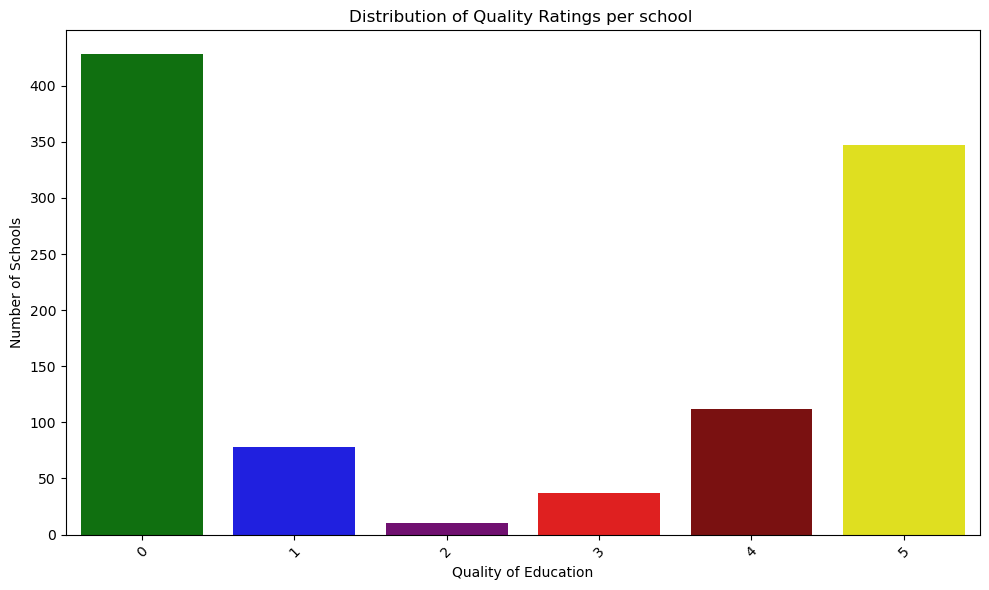

In [5]:

if texts:

    quality_df['KwaliteiOnderwijs'] = quality_df['KwaliteiOnderwijs'].map({
        'Zeer zwak': 3, 'Basistoezicht': 2, 'Onvoldoende': 4, 'Voldoende': 0, 'Goed': 1,'Geen eindoordeel':5
    })
    valid_brin_values = [brin for brin in brin_values if brin in quality_df['Brin'].values]
    quality_ratings = quality_df.set_index('Brin').loc[valid_brin_values, 'KwaliteiOnderwijs'].values
    vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.7)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("Original class distribution:")
    print(pd.Series(quality_ratings).value_counts(ascending= False))

    feature_names = vectorizer.get_feature_names_out()
    index = pd.MultiIndex.from_arrays([range(1, len(brin_values) + 1), brin_values], names=['Row_Number', 'Brin'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=index)
    tfidf_df['Brin'] = brin_values
    updated_csv_path = '/Users/sanam/Desktop/thesis/school_data_with_features.csv'
    tfidf_df.to_csv(updated_csv_path)
    print("CSV file has been updated with TF-IDF features.")
    colors = {
        0: 'Green',       # Voldoende
        1: 'Blue',        # Goed
        2: 'Purple',  # Onvoldoende
        3: 'red',
        4: 'darkred',
        5: 'yellow'    # Zeer zwak
    }
    
    # Create a custom color map for the plot
    color_list = [colors.get(i) for i in range(6)]
    plt.figure(figsize=(10, 6))
    sns.countplot(x=quality_ratings,palette=color_list)
    plt.title('Distribution of Quality Ratings per school ')
    plt.xlabel('Quality of Education')
    plt.ylabel('Number of Schools')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


else:
    print("No documents to process.")

Topic 0:
wpo artikel zwak herstelonderzoek herstelopdracht ontbreken ononderbroken schoolgids uiterlijk maatregel
Topic 1:
eindoordeel schoolleiding curriculum toelichting opvolgen samenhangen basisvaardighed beslisregel herstelopdracht beleid
Topic 2:
nederlands uitgangssituatie financieel buitenland schoolleider online principe waarderen klimaat primair
Topic 3:
educatie kleuter samenwerking voorschool gemeente voorschools obs basisschol schoolbestuur basisschool
Topic 4:
basisschool oorde waardering waarderen zelfevaluatie vereist competentie basiskwaliteit maatschappelijk signal
1012
(1012, 5)
[[0.04199621 0.22123785 0.01117057 0.01725028 0.01821309]
 [0.         0.01115889 0.23645093 0.02056785 0.04809912]
 [0.1619354  0.01078713 0.         0.03706693 0.01339537]
 ...
 [0.07399157 0.         0.00866157 0.02417841 0.13684816]
 [0.11598751 0.16419532 0.         0.         0.        ]
 [0.07069055 0.00239583 0.02291157 0.         0.13721725]]
(5, 932)
       Topic_0   Topic_1   Topic

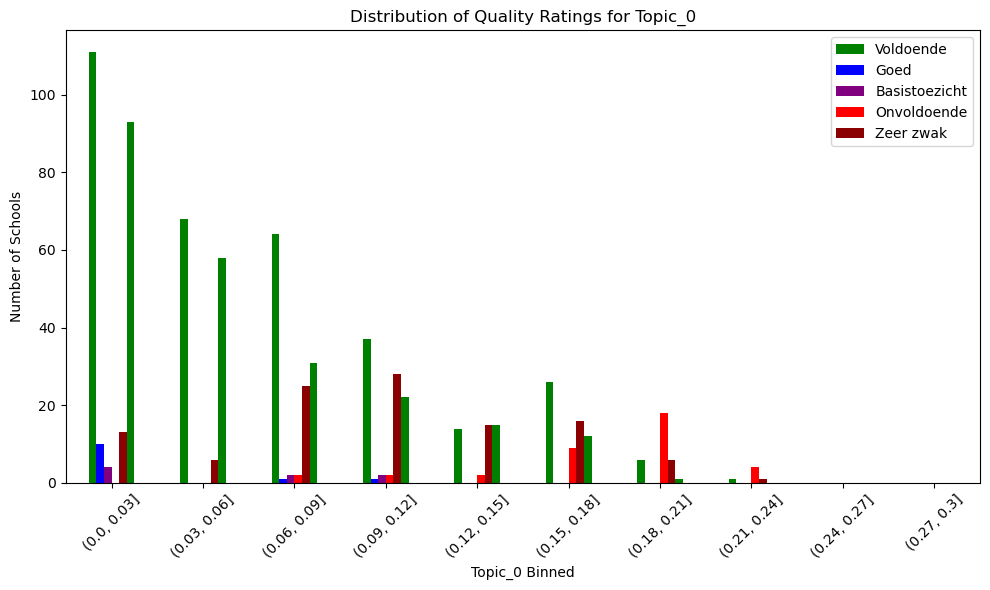

we are hre


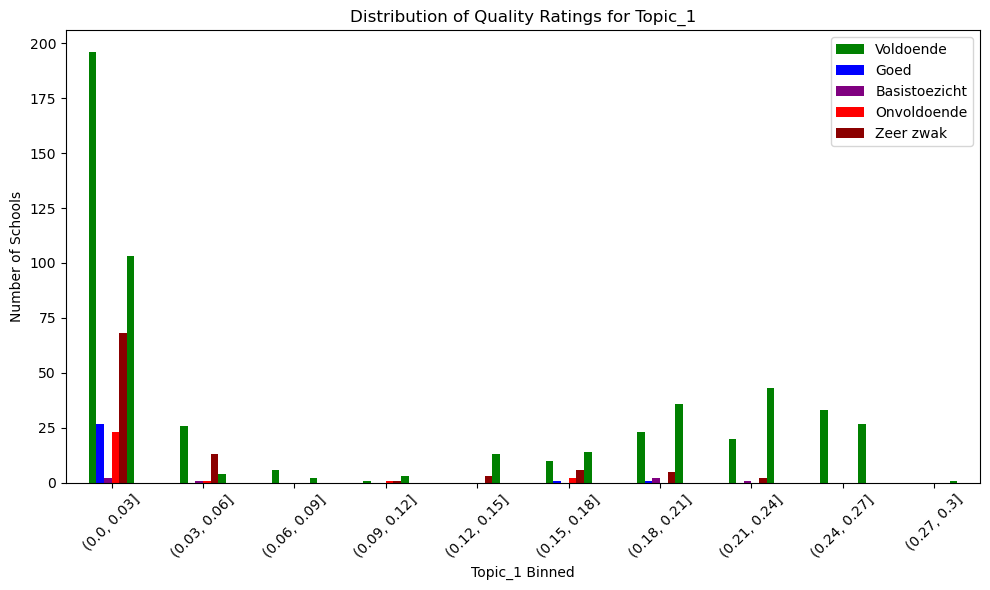

we are hre


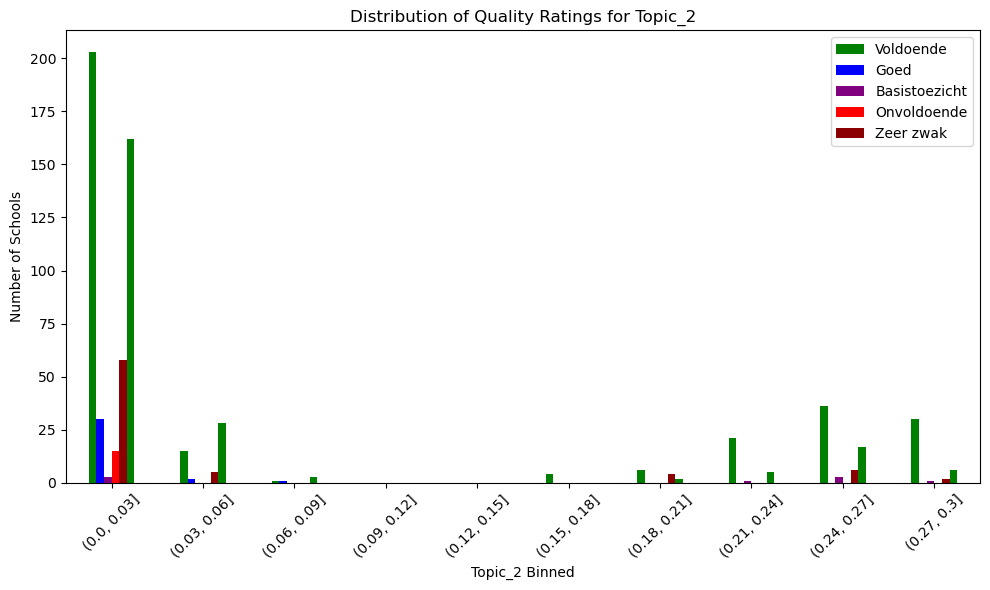

we are hre


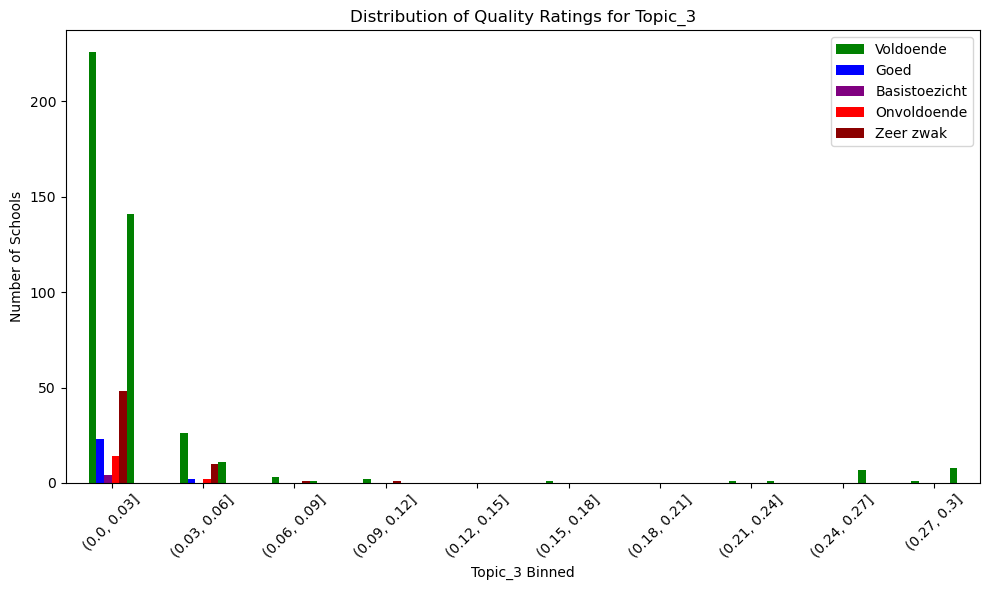

we are hre


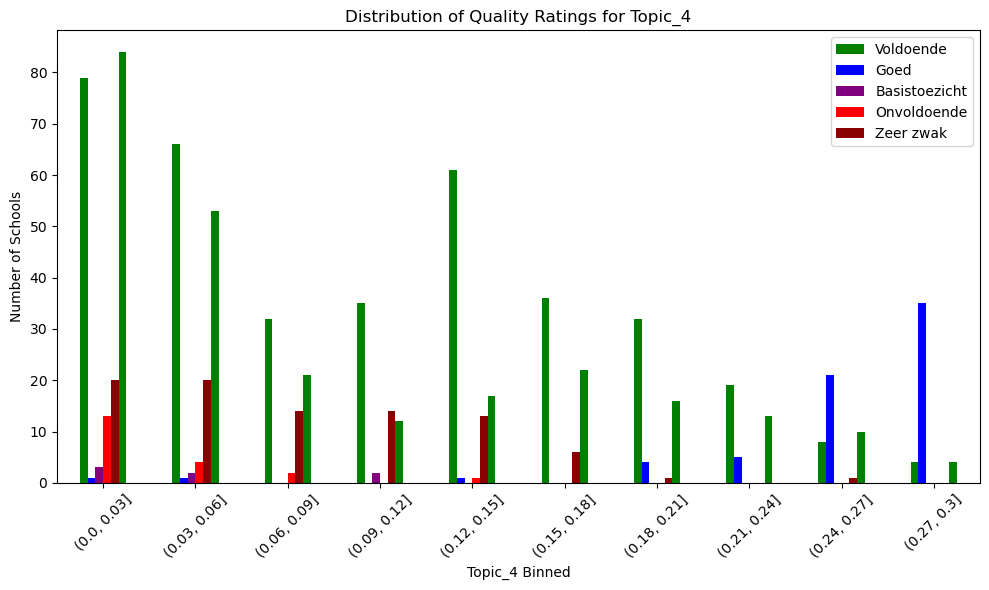

In [6]:

num_topics = 5  # You can change the number of topics as needed
nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=600)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

# Extract top terms for each topic
feature_names = vectorizer.get_feature_names_out()
topics = [[feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in H]

for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))

print(len(brin_values))

assert len(brin_values)== W.shape[0], "Mismatch in length of Brin values and W matrix rows"
assert len(quality_ratings) == W.shape[0], "Mismatch in length of q values and H matrix rows"


# Create DataFrame
print(W.shape)
print(W)
print(H.shape)
topic_df = pd.DataFrame(W, columns=[f'Topic_{i}' for i in range(num_topics)])
print(topic_df)
topic_df['Brin'] = brin_values
topic_df['KwaliteiOnderwijs'] = quality_ratings

# Filter out rows where KwaliteiOnderwijs is 5
# topic_df = topic_df[topic_df['KwaliteiOnderwijs'] != 5]

topic_df.to_csv("topicperschoolall.csv", index=False)



# Function to bin topic contributions and plot the distribution of quality ratings per topic
import matplotlib.pyplot as plt
import pandas as pd

def plot_quality_distribution_per_topic(topic_df, topic_column, bins):
    # Bin the topic contributions
    topic_df[f'{topic_column}_binned'] = pd.cut(topic_df[topic_column], bins=bins)
    
    # Group by the binned topic contributions and count quality ratings
    topic_class_distribution = topic_df.groupby(f'{topic_column}_binned')['KwaliteiOnderwijs'].value_counts().unstack().fillna(0)
    
    # Define custom colors for each quality rating
    colors = {
        0: 'green',       # Voldoende
        1: 'blue',        # Goed
        2: 'purple',      # Basistoezicht
        3: 'red',         # Onvoldoende
        4: 'darkred'      # Zeer zwak
    }
    
    # Create a custom color map for the plot
    color_list = [colors.get(i) for i in range(5)]
    
    # Plot the distribution of classes per topic using a grouped bar chart
    topic_class_distribution.plot(kind='bar', figsize=(10, 6), color=color_list)
    print("we are hre")
    plt.title(f'Distribution of Quality Ratings for {topic_column}')
    plt.xlabel(f'{topic_column} Binned')
    plt.ylabel('Number of Schools')
    plt.xticks(rotation=45)
    plt.legend(['Voldoende', 'Goed', 'Basistoezicht', 'Onvoldoende', 'Zeer zwak'])
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming topic_df is your DataFrame, 'Topic_1' is the topic column, and you want 10 bins

# Plot for each topic
for i in range(0, num_topics ):
    start = 0.0
    end = 0.3
    num_bins = 10
# Create the bins
    bins = np.linspace(start, end, num_bins + 1)
    plot_quality_distribution_per_topic(topic_df, f'Topic_{i}', bins)



In [7]:
def calculate_coherence_score(num_topics, tfidf_matrix, vectorizer, texts):
    nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=600)
    W = nmf_model.fit_transform(tfidf_matrix)
    H = nmf_model.components_

    topics = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in H]

    processed_texts = [text.split() for text in texts]
    
    id2word = Dictionary(processed_texts)
    coherence_model = CoherenceModel(topics=topics, texts=processed_texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    return coherence_score

Number of Topics: 2, Coherence Score: 0.42777735727988875
Number of Topics: 3, Coherence Score: 0.4849483619259078
Number of Topics: 4, Coherence Score: 0.5973096322947775
Number of Topics: 5, Coherence Score: 0.6247928095252988
Number of Topics: 6, Coherence Score: 0.618528887871942
Number of Topics: 7, Coherence Score: 0.5827169387632191
Number of Topics: 10, Coherence Score: 0.5364040189932081
Number of Topics: 20, Coherence Score: 0.5100226238264621


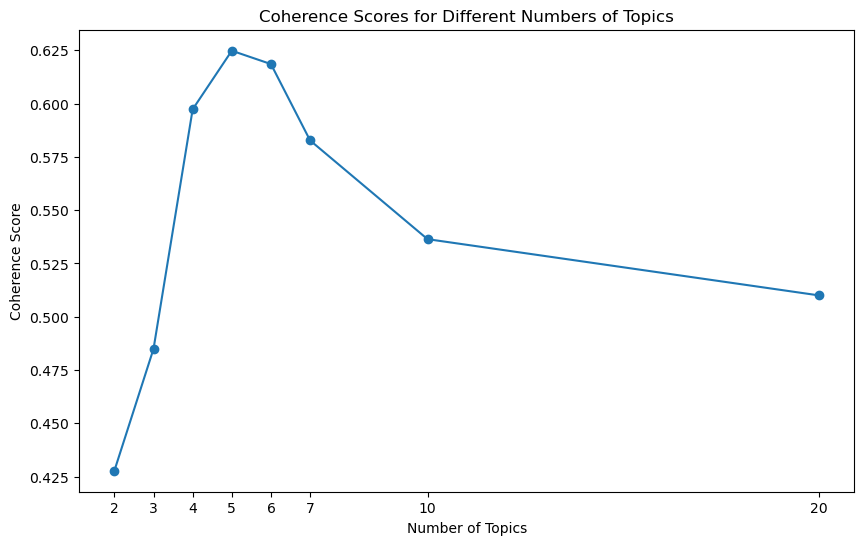

The best number of topics is: 5


In [8]:


    # Calculate coherence scores for different numbers of topics
num_topics_list = [2, 3, 4, 5, 6,7, 10,20]
coherence_scores = []

for num_topics in num_topics_list:
        coherence_score = calculate_coherence_score(num_topics, tfidf_matrix, vectorizer, texts)
        coherence_scores.append(coherence_score)
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Coherence Scores for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)  # Set the x-axis ticks to match num_topics_list
plt.show()

# Select the number of topics with the highest coherence score
best_num_topics = num_topics_list[np.argmax(coherence_scores)]
print(f"The best number of topics is: {best_num_topics}")


In [9]:
excel_file_path = '/Users/sanam/Downloads/schoolweging_2020-2023.xlsx'
table3 = pd.read_excel(excel_file_path, sheet_name='Tabel 3')

In [10]:
header_row = 2 # Adjust based on where the actual headers are located

# Set the correct column names and drop initial rows
table3.columns = table3.iloc[header_row]
table3 = table3.drop([0, 1, 2, 3])
table3.columns = table3.columns.str.strip()  # Standardize column names

# Display the columns to ensure they are set correctly
print("\nColumns after setting headers and dropping initial rows:")
print(table3.columns)



Columns after setting headers and dropping initial rows:
Index(['BRIN', 'Vestiging', 'Nummer bevoegd gezag', 'Schoolweging',
       'Spreiding', 'Aantal leerlingen'],
      dtype='object', name=2)


In [11]:
relevant_columns = ['BRIN', 'Schoolweging', 'Spreiding', 'Aantal leerlingen']
try:
    table3 = table3[relevant_columns]
    print("\nTable 3 Structure after selecting relevant columns:")
    print(table3.head(10))
except KeyError as e:
    print(f"\nKeyError: {e}")
    print("Available columns:", table3.columns)

# Drop rows with missing values in the specified columns
table3 = table3.dropna(subset=relevant_columns)
table3 = table3.reset_index(drop=True)



Table 3 Structure after selecting relevant columns:
2   BRIN Schoolweging Spreiding Aantal leerlingen
4   00AP         31.3      8.37               109
5   00AR        28.12      5.93               140
6   00AV        30.38       6.1                71
7   00AZ        32.25      6.76                90
8   00BB        33.49      5.22                79
9   00BS        29.57      5.43               101
10  00BW        28.36      6.55               113
11  00CD        30.52      6.39               220
12  00CG        31.19       6.5               431
13  00CS        30.23      5.99                70


In [14]:
table3['Schoolweging'] = pd.to_numeric(table3['Schoolweging'], errors='coerce')
table3['Spreiding'] = pd.to_numeric(table3['Spreiding'], errors='coerce')
table3['Aantal leerlingen'] = pd.to_numeric(table3['Aantal leerlingen'], errors='coerce')

# Standardize the BRIN column
table3['BRIN'] = table3['BRIN'].str.strip().str.upper()

# Save the cleaned Table 3 data to a CSV file
csv_file_path = 'table3_cleaned.csv'
table3.to_csv(csv_file_path, index=False)
print(len(table3_cleaned['BRIN']))
# Confirm the CSV file has been saved
print(f"Table 3 data has been successfully saved to {csv_file_path}")

6153
Table 3 data has been successfully saved to table3_cleaned.csv


In [13]:
table3_cleaned_path = 'table3_cleaned.csv'
table3_cleaned = pd.read_csv(table3_cleaned_path)
print(len(table3_cleaned['BRIN']))
# Load the topic data from the CSV file
# topic_data_path = 'topicperschool.csv'
# topic_data = pd.read_csv(topic_data_path)
# print(topic_data['Brin'])
print(len(topic_df['Brin']))
topic_df = topic_df.rename(columns={'Brin': 'BRIN'})
print(len(topic_df['BRIN']))
# topic_data



6153
1012
1012


In [15]:
table3_cleaned['BRIN'] = table3_cleaned['BRIN'].str.strip().str.upper()
print(topic_df['BRIN'])
topic_df['BRIN'] = topic_df['BRIN'].str.strip().str.upper()
print(topic_df['BRIN'])

# Merge the cleaned Table 3 data with the topic data on 'BRIN'
# Merge the cleaned Table 3 data with the topic data on 'BRIN'
merged_df = pd.merge(table3_cleaned, topic_df[['BRIN', 'KwaliteiOnderwijs','Topic_0','Topic_1','Topic_2','Topic_3','Topic_4']], on='BRIN', how='inner')
merged_df = merged_df.drop(columns=['Spreiding','Aantal leerlingen'])
# Save to CSV
merged_df.to_csv('TL3mergeTopic.csv', index=False)
# Display the merged dataframe
print("\nMerged DataFrame:")
print(merged_df.head(50))

merged_df.to_csv('TL3mergeTopic.csv')
# Display the merged dataframe
print("\nMerged DataFrame:")
merged_df.shape
print(len(merged_df["BRIN"]))
print(merged_df.head(50))

0       27YP
1       29TX
2       10BF
3       08SY
4       31DT
        ... 
1007    29WY
1008    17FR
1009    10CO
1010    03BA
1011    04EC
Name: BRIN, Length: 1012, dtype: object
0       27YP
1       29TX
2       10BF
3       08SY
4       31DT
        ... 
1007    29WY
1008    17FR
1009    10CO
1010    03BA
1011    04EC
Name: BRIN, Length: 1012, dtype: object

Merged DataFrame:
    BRIN  Schoolweging  KwaliteiOnderwijs   Topic_0   Topic_1   Topic_2  \
0   00BB         33.49                  5  0.067488  0.014496  0.000000   
1   00BW         28.36                  5  0.041478  0.000000  0.003909   
2   00DO         32.85                  0  0.001354  0.000125  0.001515   
3   00FI         31.10                  0  0.029672  0.010321  0.000000   
4   01VG         30.35                  5  0.027237  0.027811  0.001133   
5   01VG         21.94                  5  0.027237  0.027811  0.001133   
6   01XU         22.51                  1  0.000000  0.000000  0.000000   
7   03AH       

# import

In [16]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# Removing outlires

In [17]:

target = 'Schoolweging'

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = merged_df[target].quantile(0.25)
Q3 = merged_df[target].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
merged_df_no_outliers = merged_df[(merged_df[target] >= lower_bound) & (merged_df[target] <= upper_bound)]
merged_df.to_excel("merged.xlsx")



In [59]:
overall_mean = merged_df['Schoolweging'].mean()
X_train, X_test, y_train, y_test = train_test_split(
    merged_df[['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4']],  
    merged_df['Schoolweging'], 
    test_size=0.2,  
    random_state=42,  
    stratify=(merged_df['Schoolweging'] > overall_mean)
)

# balancing data

count    825.000000
mean      30.974412
std        3.845600
min       20.630000
25%       28.300000
50%       30.800000
75%       33.830000
max       39.540000
Name: Schoolweging, dtype: float64
Skewness: -0.031902892698492995
Kurtosis: -0.6184007804795857
0.25    28.30
0.50    30.80
0.75    33.83
Name: Schoolweging, dtype: float64


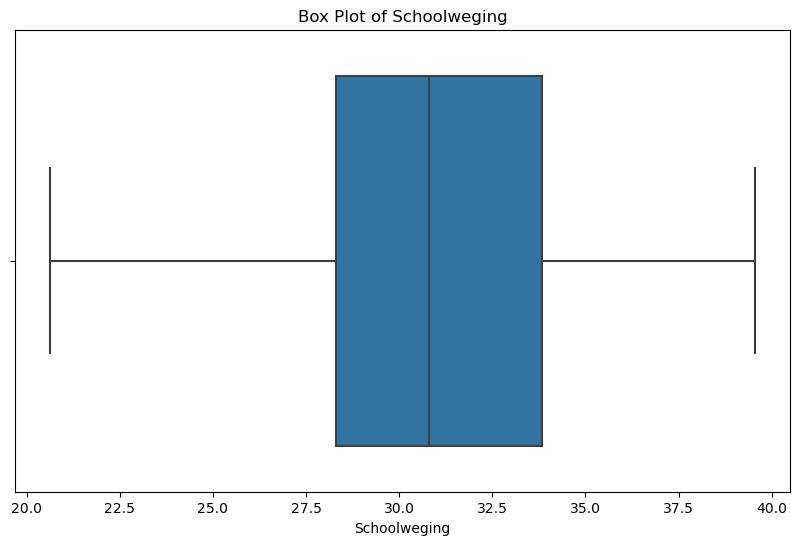

/var/folders/35/m9jg2n791l542p5mnwq18ldw0000gn/T/ipykernel_61556/218395980.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['Schoolweging'], shade=True)


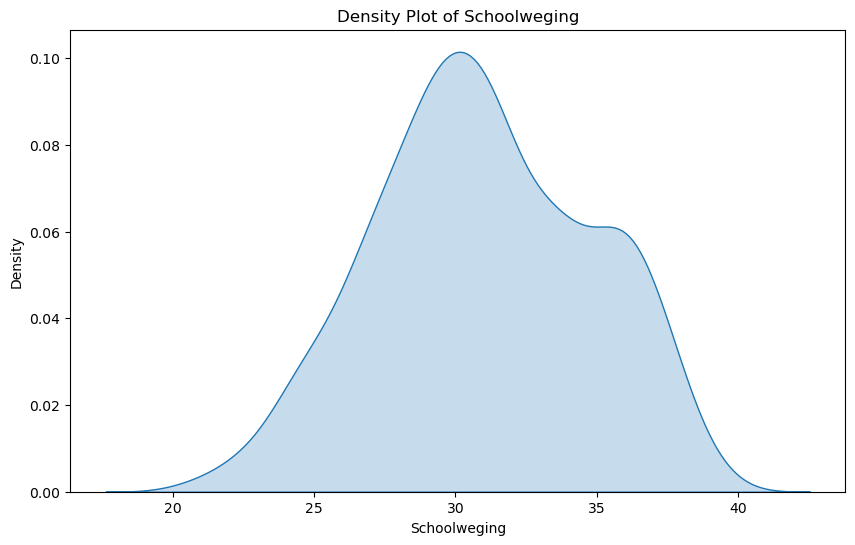

count    660.000000
mean      30.974121
std        3.834415
min       20.630000
25%       28.292500
50%       30.795000
75%       33.860000
max       39.290000
Name: Schoolweging, dtype: float64
count    165.000000
mean      30.975576
std        3.901793
min       20.910000
25%       28.300000
50%       30.820000
75%       33.770000
max       39.540000
Name: Schoolweging, dtype: float64


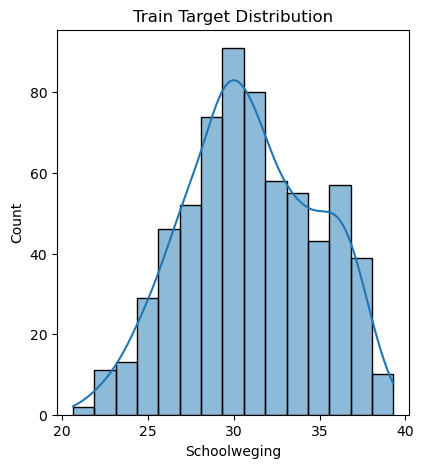

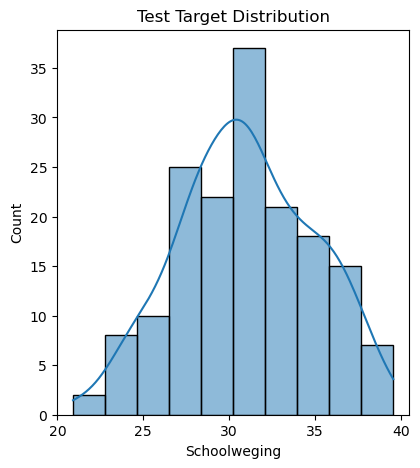

In [39]:
print(merged_df['Schoolweging'].describe())

# Skewness and Kurtosis
print(f"Skewness: {merged_df['Schoolweging'].skew()}")
print(f"Kurtosis: {merged_df['Schoolweging'].kurt()}")

# Quantile Analysis
quantiles = merged_df['Schoolweging'].quantile([0.25, 0.5, 0.75])
print(quantiles)

# Box Plot for outlier detection
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['Schoolweging'])
plt.title('Box Plot of Schoolweging')
plt.show()

# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(merged_df['Schoolweging'], shade=True)
plt.title('Density Plot of Schoolweging')
plt.show()

# Split the data into training and test sets


# Split the data using stratified sampling based on 'Schoolweging' values



# Visualize the original target distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title('Train Target Distribution')
print(y_train.describe())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_test, kde=True)
plt.title('Test Target Distribution')
print(y_test.describe())



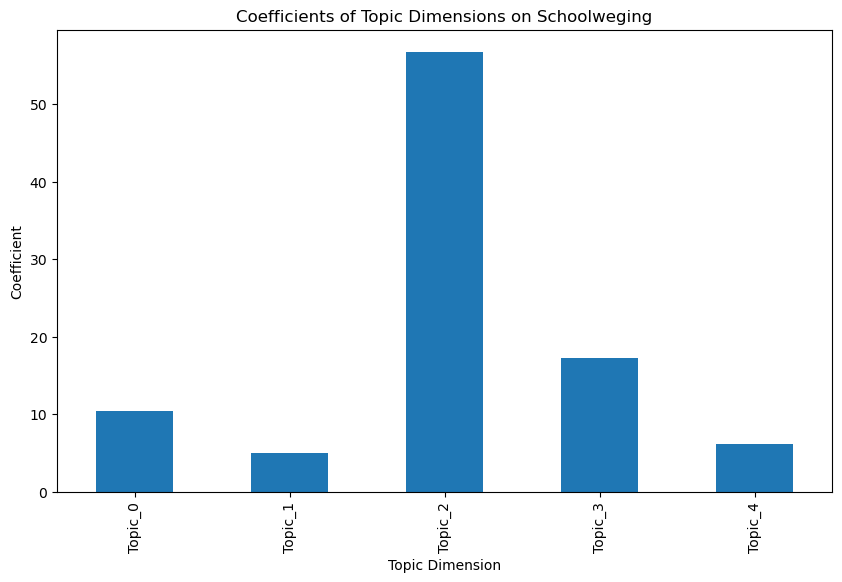

P-values for each variable:
const      7.796651e-51
Topic_0    2.246356e-01
Topic_1    4.062829e-01
Topic_2    6.700061e-06
Topic_3    2.826370e-04
Topic_4    3.388131e-01
dtype: float64
Coefficient for each variable:
const      28.242432
Topic_0    10.462314
Topic_1     4.952428
Topic_2    56.739200
Topic_3    17.258620
Topic_4     6.096660
dtype: float64
Training RMSE: 3.564488715420814
Test RMSE: 3.9473529359564883


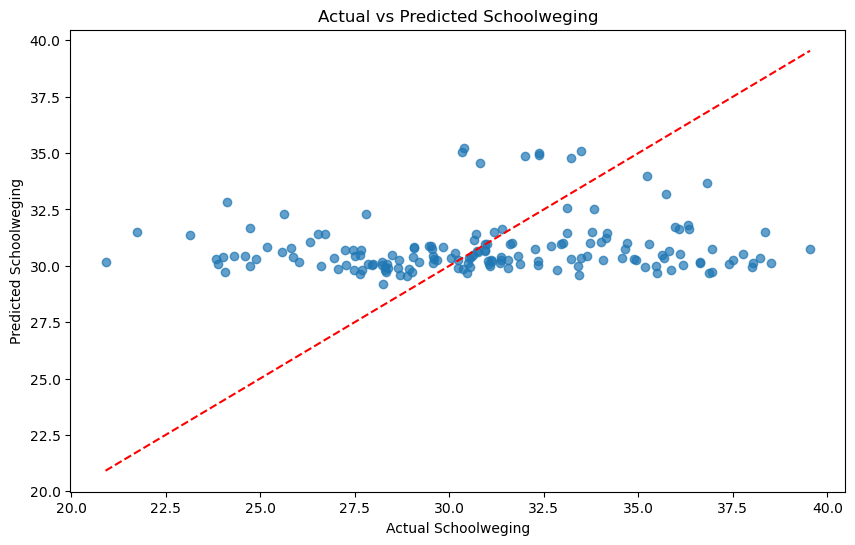

Index(['Topic_2', 'Topic_3'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           Schoolweging   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     20.33
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           6.90e-19
Time:                        09:23:39   Log-Likelihood:                -1775.4
No. Observations:                 660   AIC:                             3563.
Df Residuals:                     654   BIC:                             3590.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

In [55]:

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the regression model
model = sm.OLS(y_train, X_train_const).fit()
coefficients = pd.Series(model.params, index=X_train_const.columns)
p_values = pd.Series(model.pvalues, index=X_train_const.columns)

# Combine coefficients and p-values into a DataFrame for better visualization
coef_pval_df = pd.DataFrame({'Coefficient': coefficients, 'P-value': p_values})
coef_pval_df = coef_pval_df.drop(index='const')
# Plot coefficients with p-values
plt.figure(figsize=(10, 6))
coef_pval_df['Coefficient'].plot(kind='bar', capsize=5)
plt.title('Coefficients of Topic Dimensions on Schoolweging')
plt.xlabel('Topic Dimension')
plt.ylabel('Coefficient')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.show()

# Display the p-values
print("P-values for each variable:")
print(p_values)
print("Coefficient for each variable:")
print(coefficients)

# Make predictions
y_pred_train = model.predict(X_train_const)
y_pred_test = model.predict(X_test_const)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.title('Actual vs Predicted Schoolweging')
plt.xlabel('Actual Schoolweging')
plt.ylabel('Predicted Schoolweging')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


significant_vars = p_values[p_values < 0.05].index[1::]
print(significant_vars)
# Sort the significant coefficients in descending order
most_influential = coefficients[significant_vars].sort_values(ascending=False)

print(model.summary())
# Display the most influential topics
print("Most influential topics:")
print(most_influential)


selected_features : [False False  True  True False]
selected_features : Index(['Topic_2', 'Topic_3'], dtype='object')
Mean Squared Error train: 3.5707
Mean Squared Error test: 3.9465
Most influential topic dimensions on Schoolweging:
Topic_2    51.960257
Topic_3    12.621491
dtype: float64


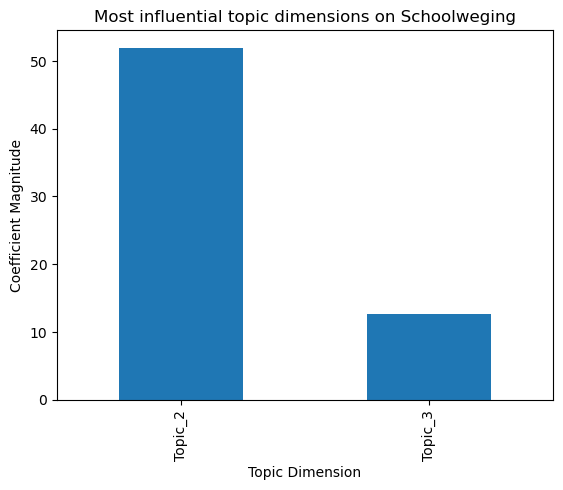

     Actual  Predicted
143   29.52  30.931144
807   26.33  31.153538
582   30.74  30.937180
61    29.05  30.083026
163   31.54  30.000885
30.975575757575754
30.974121212121208


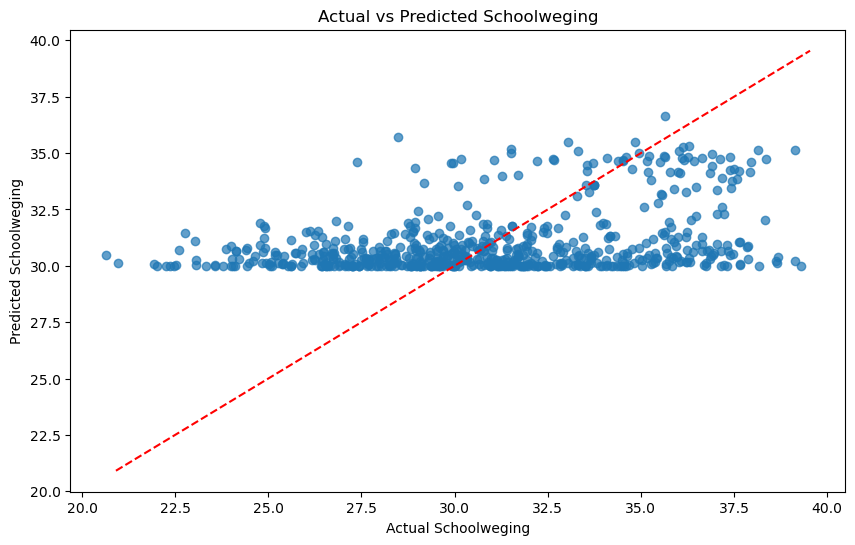

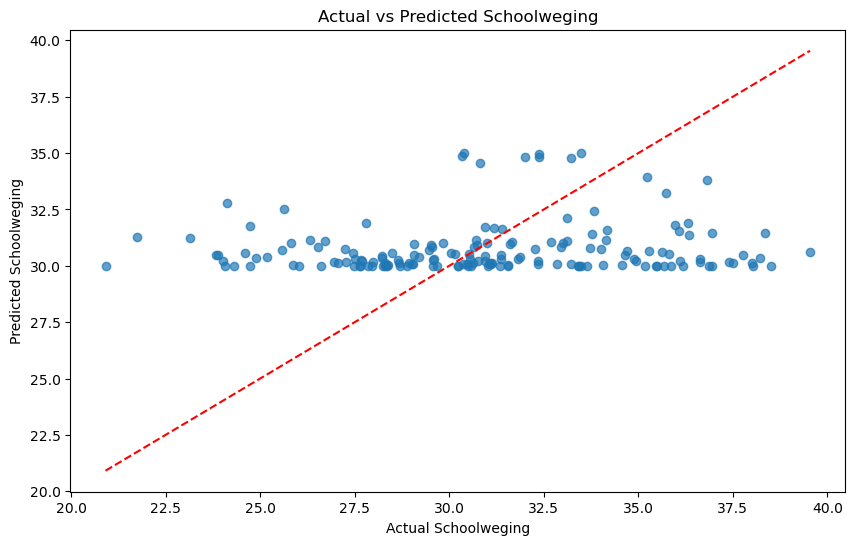

In [56]:
model = LinearRegression()
sfs = SequentialFeatureSelector(model, direction='forward', n_features_to_select='auto')
sfs.fit(X_train, y_train)

# Get selected features
print("selected_features :" ,sfs.get_support())
selected_features = X_train.columns[sfs.get_support()]
print("selected_features :" ,selected_features)
# Fit model with selected features
model.fit(X_train[selected_features], y_train)

y_pred_train = model.predict(X_train[selected_features])
y_pred_test = model.predict(X_test[selected_features])
# Coefficients

mse = mean_squared_error(y_train, y_pred_train,squared=False)
print(f'Mean Squared Error train: {mse:.4f}')

mse = mean_squared_error(y_test, y_pred_test,squared=False)
print(f'Mean Squared Error test: {mse:.4f}')

# Coefficients
coefficients = pd.Series(model.coef_, index=selected_features)
most_influential = coefficients.sort_values(ascending=False)

# Display the most influential topics
print("Most influential topic dimensions on Schoolweging:")
print(most_influential)

# Plot coefficients
most_influential.plot(kind='bar', title='Most influential topic dimensions on Schoolweging')
plt.xlabel('Topic Dimension')
plt.ylabel('Coefficient Magnitude')
plt.show()
# Compare actual vs. predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
print(results_df.head())

print(y_test.mean())
print(y_pred_train.mean())
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.7)
plt.title('Actual vs Predicted Schoolweging')
plt.xlabel('Actual Schoolweging')
plt.ylabel('Predicted Schoolweging')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.title('Actual vs Predicted Schoolweging')
plt.xlabel('Actual Schoolweging')
plt.ylabel('Predicted Schoolweging')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()



In [ ]:
# import 

# import


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt



30.974121212121208
30.974121212121208


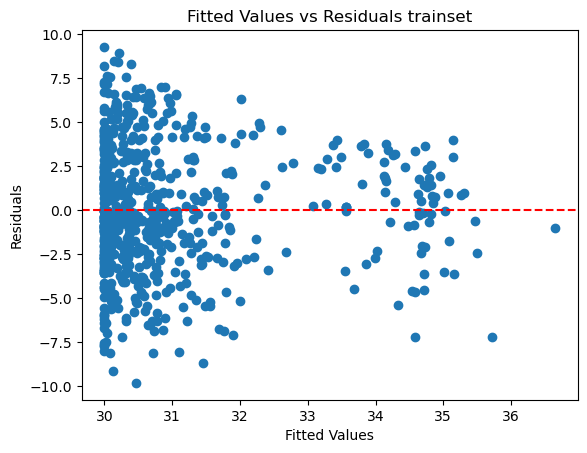

In [58]:

residuals = y_train - y_pred_train
print(y_train.mean())
print(y_pred_train.mean())
plt.scatter(y_pred_train, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals trainset')
plt.show()

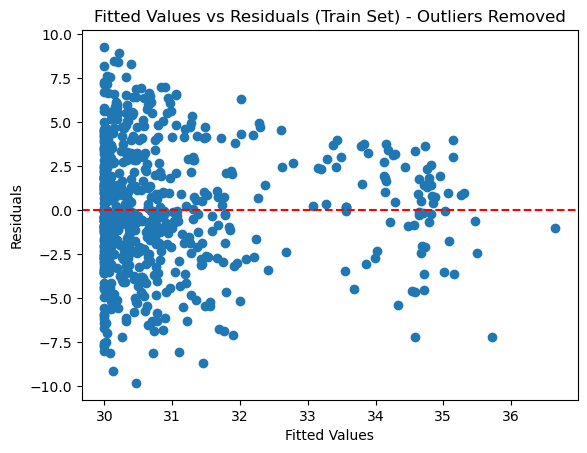

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_train - y_pred_train

# Calculate mean and standard deviation of residuals
residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)

# Define a threshold for outliers (for example, 3 standard deviations)
threshold = 3 * residuals_std

# Filter out outliers
filtered_indices = np.abs(residuals - residuals_mean) <= threshold
y_train_filtered = y_train[filtered_indices]
y_pred_train_filtered = y_pred_train[filtered_indices]
residuals_filtered = residuals[filtered_indices]

# Plot the filtered residuals
plt.scatter(y_pred_train_filtered, residuals_filtered)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals (Train Set) - Outliers Removed')
plt.show()


30.975575757575754
30.76547531879876


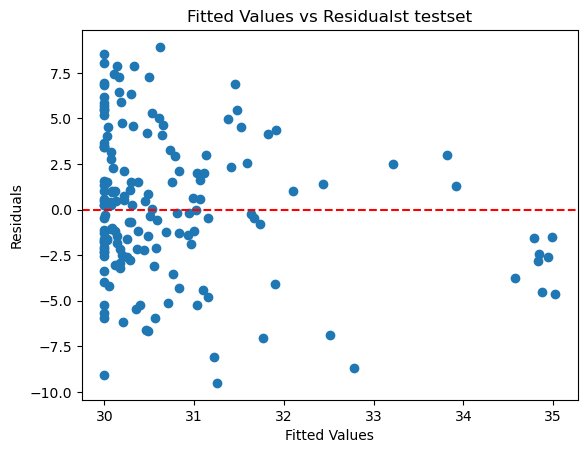

In [31]:

# Predict on the test set
residuals = y_test - y_pred_test
print(y_test.mean())
print(y_pred_test.mean())

plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residualst testset')
plt.show()


Permutation Importance of Features:
   Feature  Importance
1  Topic_4    0.143911
0  Topic_2    0.011931


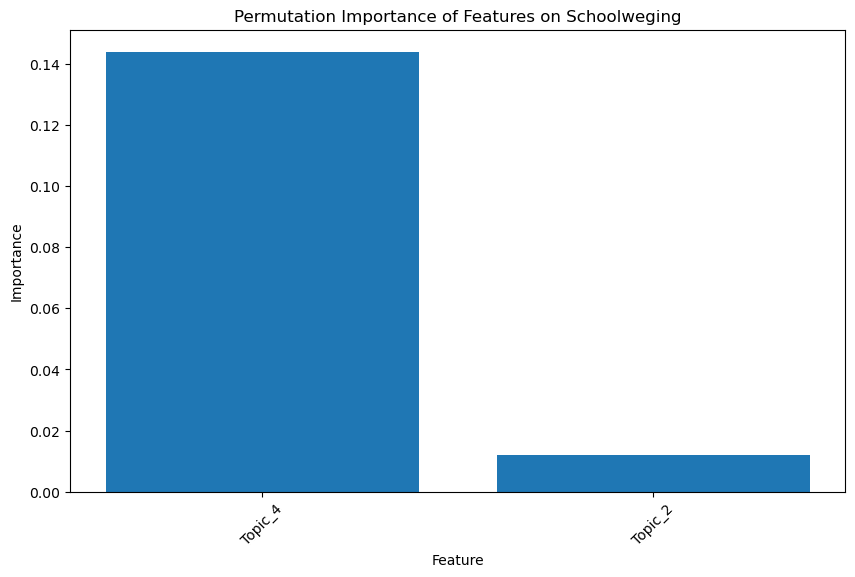

In [ ]:
import numpy as np
from sklearn.inspection import permutation_importance

# Fit the model again with all features

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test[selected_features], y_test, n_repeats=30, random_state=42)

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': perm_importance.importances_mean})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the permutation importance
print("Permutation Importance of Features:")
print(importance_df)

# Plot the permutation importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Permutation Importance of Features on Schoolweging')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = merged_df[['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

   Feature       VIF
0  Topic_1  1.314809
1  Topic_2  1.424867
2  Topic_3  1.082378
3  Topic_4  1.034449
4  Topic_5  1.183185


Mean Squared Error: 12.0155
Most influential topic dimensions on Schoolweging:
Topic_2              73.872538
Topic_4              12.581694
Topic_5               2.389354
Aantal leerlingen     0.005495
dtype: float64


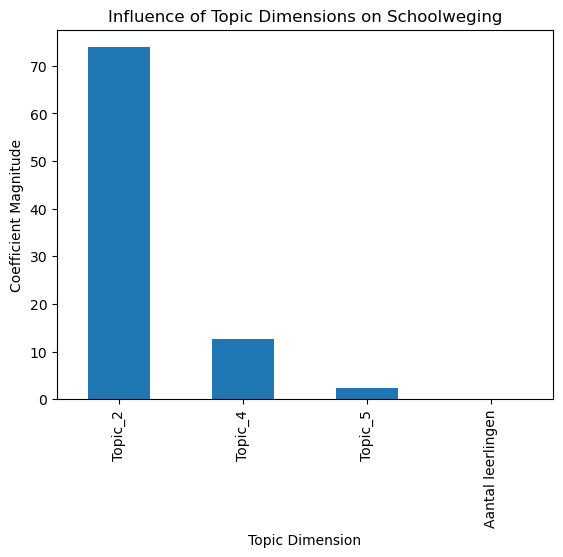

     Actual  Predicted
611   26.74  28.820714
174   29.07  30.445920
67    27.67  30.614274
168   30.59  31.070015
275   34.65  30.480275


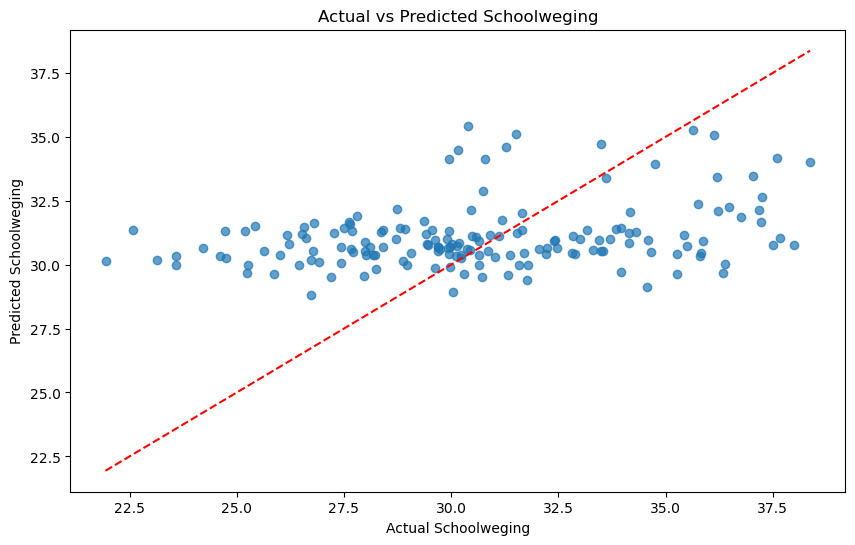

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt


# Prepare data
X = merged_df[['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'KwaliteiOnderwijs', 'Spreiding', 'Aantal leerlingen']]
y = merged_df['Schoolweging']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stepwise regression
model = LinearRegression()
sfs = SequentialFeatureSelector(model, direction='forward', n_features_to_select='auto')
sfs.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[sfs.get_support()]

# Fit model with selected features
model.fit(X_train[selected_features], y_train)

# Predict on the test set
y_pred = model.predict(X_test[selected_features])

# Calculate and print MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

# Coefficients
coefficients = pd.Series(model.coef_, index=selected_features)
most_influential = coefficients.sort_values(ascending=False)

# Display the most influential topics
print("Most influential topic dimensions on Schoolweging:")
print(most_influential)

# Plot coefficients
most_influential.plot(kind='bar', title='Influence of Topic Dimensions on Schoolweging')
plt.xlabel('Topic Dimension')
plt.ylabel('Coefficient Magnitude')
plt.show()

# Compare actual vs. predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df.head())

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('Actual vs Predicted Schoolweging')
plt.xlabel('Actual Schoolweging')
plt.ylabel('Predicted Schoolweging')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


R-squared: 0.0826
Mean Absolute Error: 2.8568
Root Mean Squared Error: 3.4663


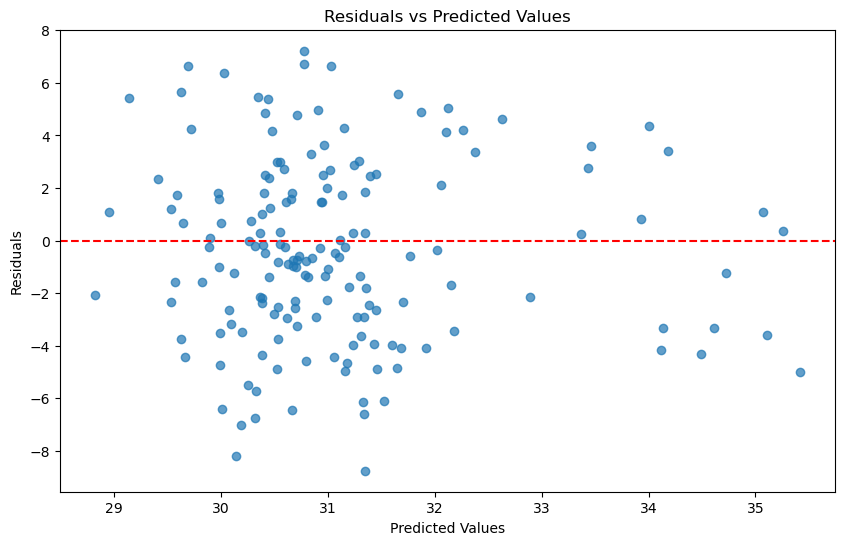

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate and print R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

# Calculate and print MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.4f}')

# Calculate and print RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.4f}')

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Mean Squared Error: 12.0155
Mean Absolute Error: 2.8568
Root Mean Squared Error: 3.4663
R-squared: 0.0826
Most influential topic dimensions on Schoolweging:
Topic_4              1.166049
Aantal leerlingen    0.775703
Topic_2              0.497045
Topic_5              0.202458
dtype: float64


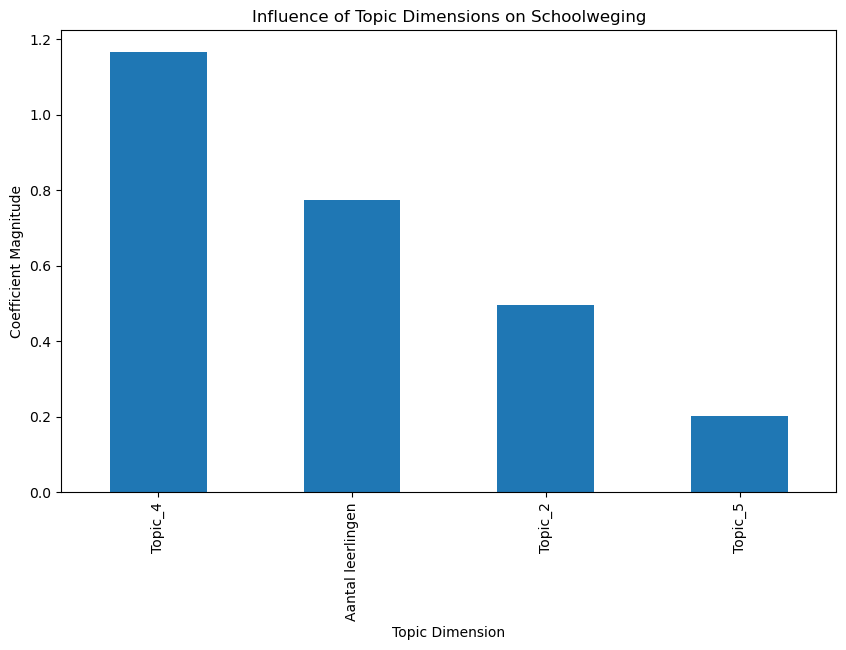

     Actual  Predicted
611   26.74  28.820714
174   29.07  30.445920
67    27.67  30.614274
168   30.59  31.070015
275   34.65  30.480275


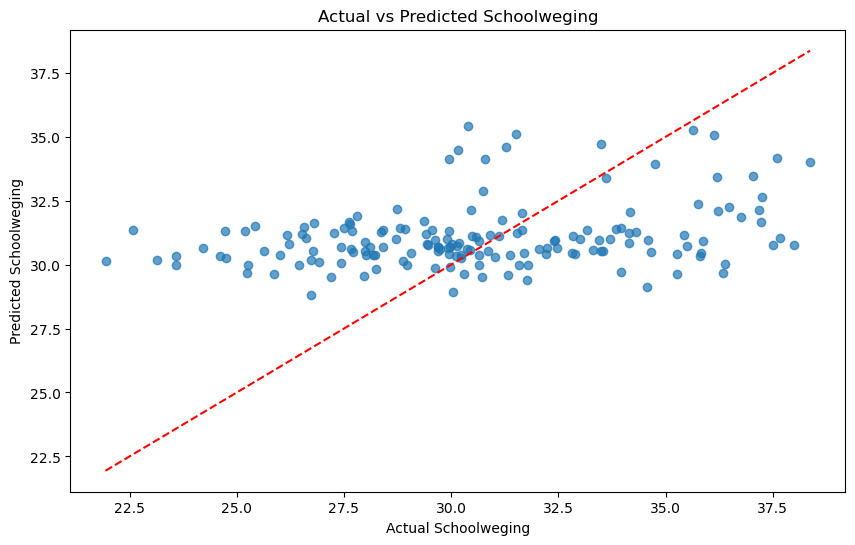

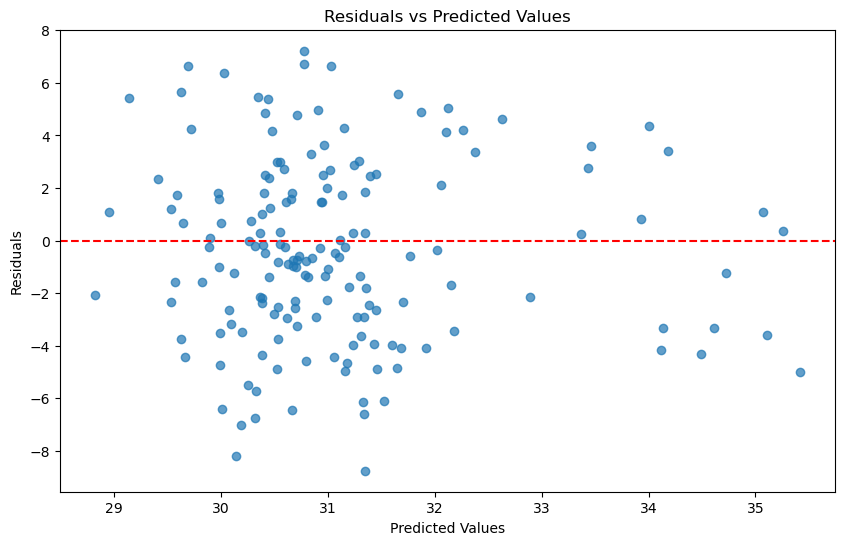

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming merged_df is already defined and includes the additional columns
# Prepare data
X = merged_df[['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'KwaliteiOnderwijs', 'Spreiding', 'Aantal leerlingen']]
y = merged_df['Schoolweging']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Stepwise regression to identify most influential features
model = LinearRegression()
sfs = SequentialFeatureSelector(model, direction='forward', n_features_to_select='auto')
sfs.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[sfs.get_support()]

# Fit model with selected features
model.fit(X_train[selected_features], y_train)

# Predict on the test set
y_pred = model.predict(X_test[selected_features])

# Calculate and print MSE, MAE, RMSE, and R-squared
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared: {r2:.4f}')

# Coefficients
coefficients = pd.Series(model.coef_, index=selected_features)
most_influential = coefficients.abs().sort_values(ascending=False)

# Display the most influential topics
print("Most influential topic dimensions on Schoolweging:")
print(most_influential)

# Plot coefficients
plt.figure(figsize=(10, 6))
most_influential.plot(kind='bar', title='Influence of Topic Dimensions on Schoolweging')
plt.xlabel('Topic Dimension')
plt.ylabel('Coefficient Magnitude')
plt.show()

# Compare actual vs. predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df.head())

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('Actual vs Predicted Schoolweging')
plt.xlabel('Actual Schoolweging')
plt.ylabel('Predicted Schoolweging')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


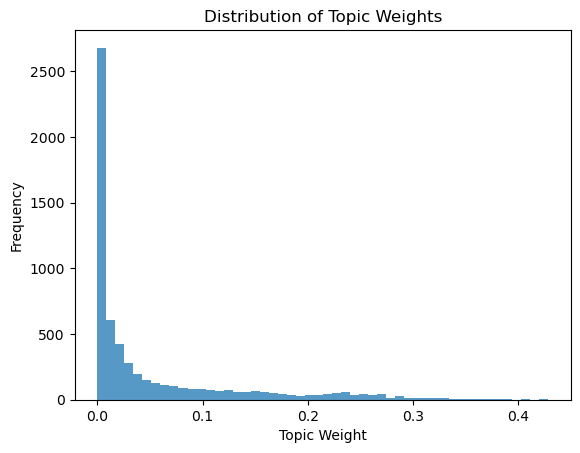

In [ ]:
weights = W.flatten()

# Plot the distribution of weights
plt.hist(weights, bins=50, alpha=0.75)
plt.xlabel('Topic Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Topic Weights')
plt.show()

In [ ]:
threshold = 0.02

# Function to assign topics to documents
def assign_topics_to_documents(W, threshold):
    document_topics = []
    for doc_idx, topic_weights in enumerate(W):
        relevant_topics = np.where(topic_weights >= threshold)[0]
        document_topics.append(relevant_topics)
    return document_topics

document_topics = assign_topics_to_documents(W, threshold)

# Display document-topic assignments
for doc_idx, topics in enumerate(document_topics):
    print(f"Document {doc_idx + 1} is related to topics: {', '.join(str(topic + 1) for topic in topics)}")

Document 1 is related to topics: 3
Document 2 is related to topics: 2, 4, 5
Document 3 is related to topics: 1, 5
Document 4 is related to topics: 1, 2, 5
Document 5 is related to topics: 4
Document 6 is related to topics: 4, 5
Document 7 is related to topics: 2
Document 8 is related to topics: 2, 3, 4
Document 9 is related to topics: 1, 2, 3, 5
Document 10 is related to topics: 3
Document 11 is related to topics: 2, 5
Document 12 is related to topics: 1
Document 13 is related to topics: 1, 3
Document 14 is related to topics: 1, 2, 3
Document 15 is related to topics: 1, 2, 4, 5
Document 16 is related to topics: 1
Document 17 is related to topics: 1, 3
Document 18 is related to topics: 1, 2, 3, 5
Document 19 is related to topics: 1, 2, 5
Document 20 is related to topics: 4
Document 21 is related to topics: 2, 4
Document 22 is related to topics: 3
Document 23 is related to topics: 4
Document 24 is related to topics: 3, 4
Document 25 is related to topics: 1, 2, 4, 5
Document 26 is related